# Co-Expression Modules

**Created**: 8 February 2022

These co-expression modules are developed based on recommendations by [Johsnon and Krishnan 2022](https://www.doi.org/10.1186/s13059-021-02568-9). These authors specifically analyzed count data from RNA-Seq rather than microarray data, which has been traditionally used to develop co-expression modules in the past. Their recommendations are:

1. Using Counts adjusted with TMM Factors (CTF) or Counts adjusted with Upper Quartile Factors (CUF) to perform between-sample normalization on count data directly.
2. After normalization, perform an `asinh` normalization.
3. Use Context Likelihood of Relatedness (CLR) to transform the network.

This is the process they used, which I will follow closely:

1. No within-sample normalization.
2. Between-sample normalization using CTF.
3. Retain only protein-coding, antisense RNA, and lncRNA genes.
4. Data transformation using $\text{asinh(x)}=\ln \left(x + \sqrt{x^2 + 1}\right)$
5. Adjacency matrix using Pearson's R between all gene pairs.
6. Network transformation using CLR.

Johnson and Krishnan 2022 do not have any recommendations on generating actual modules. One idea is to use the Dynamic Tree Cut algorithm by [Langfelder, Zhang, and Horvath 2008](https://doi.org/10.1093/bioinformatics/btm563). Options include common clustering algorithms:

1. $k$-means
2. Hierarchical clustering
3. Highly-Connected Subgraphs (HCS)
4. Dynamic Tree Cut

## Environment

In [19]:
if (!requireNamespace("edgeR", quietly=TRUE)) {
    BiocManager::install("edgeR")
}

if (!requireNamespace("igraph", quietly=TRUE)) {
    BiocManager::install("igraph")
}

if (!requireNamespace("RBGL", quietly=TRUE)) {
    BiocManager::install("RBGL")
}

if (!requireNamespace("Rcpp", quietly=TRUE)) {
    BiocManager::install("Rcpp")
}

if (!requireNamespace("Rfast", quietly=TRUE)) {
    install.packages("Rfast")
}

if (!requireNamespace("sva")) {
    BiocManager::install("sva")
}

if (!requireNamespace("spqn")) {
    BiocManager::install("spqn")
}

Loading required namespace: sva

Loading required namespace: spqn



In [20]:
library(tidyverse)
library(edgeR)
library(igraph)
library(Rcpp)
library(data.table)
library(Rfast)
library(cluster)
library(WGCNA)
library(sva)
library(spqn)
library(parallel)

setwd("~/eQTL_pQTL_Characterization/")

source("04_Expression/scripts/utils/ggplot_theme.R")

Loading required package: mgcv

Loading required package: nlme


Attaching package: ‘nlme’


The following object is masked from ‘package:dplyr’:

    collapse


This is mgcv 1.8-38. For overview type 'help("mgcv-package")'.

Loading required package: genefilter


Attaching package: ‘genefilter’


The following objects are masked from ‘package:Rfast’:

    rowVars, ttest


The following object is masked from ‘package:readr’:

    spec


Loading required package: BiocParallel

Loading required package: ggridges

Loading required package: SummarizedExperiment

Loading required package: MatrixGenerics

Loading required package: matrixStats


Attaching package: ‘matrixStats’


The following objects are masked from ‘package:genefilter’:

    rowSds, rowVars


The following objects are masked from ‘package:Rfast’:

    colMads, colMaxs, colMedians, colMins, colRanks, colVars, rowMads,
    rowMaxs, rowMedians, rowMins, rowRanks, rowVars


The following object is masked from ‘package:dplyr’:



In [3]:
Rcpp::sourceCpp("04_Expression/scripts/utils/clr.cpp")

## Load Data

In [4]:
counts <- read.table("/nfs/team282/data/gains_team282/counts_864_20412_hla.txt")

In [5]:
ga.prefix.filter <- grepl("GA", colnames(counts))
colnames(counts)[ga.prefix.filter] <- gsub("^GA", "", colnames(counts)[ga.prefix.filter])

In [6]:
head(counts)

,UK02270173_3,UK15130120_3,UK58000006_3,UK47010004_3,UK42020088_5,UK47490007_3,UK02770164_3,UK02770164_5,UK02630151_3,UK42150107_1,⋯,UK59070043_3,UK59070043_5,UK02510223_3,UK02XX0336_5,UK29090086_3,UK02XX0335_1,UK02XX0334_3,UK01210130_3,UK01210130_5,UK01380125_1
,<int>,<int>,<int>,<int>,<int>,<int>,<int>,<int>,<int>,<int>,⋯,<int>,<int>,<int>,<int>,<int>,<int>,<int>,<int>,<int>,<int>
ENSG00000230521,24,21,10,4,5,10,15,20,17,9,⋯,9,13,25,22,17,3,35,23,41,13
ENSG00000225864,40,15,16,23,5,35,5,20,4,40,⋯,18,23,27,3,14,12,17,13,15,10
ENSG00000227766,54,10,18,19,17,7,3,5,3,32,⋯,12,10,9,1,16,9,9,14,5,3
ENSG00000237669,23,26,30,16,9,32,30,21,22,32,⋯,33,15,32,32,19,23,27,32,24,40
ENSG00000271581,187,64,79,117,81,91,18,41,39,130,⋯,135,54,61,18,43,60,49,70,67,46
ENSG00000285647,0,1,0,1,18,0,0,1,17,64,⋯,286,122,1,0,0,13,11,2,2,12


In [7]:
gene.info <- read.table("/nfs/team282/data/gains_team282/gene_info_864_20412_hla.txt")

In [8]:
head(gene.info)

,seqnames,start,end,width,strand,source,type,score,phase,gene_id,⋯,transcript_source,transcript_biotype,tag,transcript_support_level,exon_number,exon_id,exon_version,protein_id,protein_version,ccds_id
,<chr>,<int>,<int>,<int>,<chr>,<chr>,<chr>,<lgl>,<lgl>,<chr>,⋯,<lgl>,<lgl>,<lgl>,<lgl>,<lgl>,<lgl>,<lgl>,<lgl>,<lgl>,<lgl>
ENSG00000230521,6,29887294,29888268,975,-,havana,gene,NA,NA,ENSG00000230521,⋯,NA,NA,NA,NA,NA,NA,NA,NA,NA,NA
ENSG00000225864,6,29722981,29723971,991,-,havana,gene,NA,NA,ENSG00000225864,⋯,NA,NA,NA,NA,NA,NA,NA,NA,NA,NA
ENSG00000227766,6,29942075,29943067,993,-,havana,gene,NA,NA,ENSG00000227766,⋯,NA,NA,NA,NA,NA,NA,NA,NA,NA,NA
ENSG00000237669,6,30006121,30007116,996,-,havana,gene,NA,NA,ENSG00000237669,⋯,NA,NA,NA,NA,NA,NA,NA,NA,NA,NA
ENSG00000271581,6,31356647,31357637,991,+,havana,gene,NA,NA,ENSG00000271581,⋯,NA,NA,NA,NA,NA,NA,NA,NA,NA,NA
ENSG00000285647,6,31367057,31376088,9032,+,havana,gene,NA,NA,ENSG00000285647,⋯,NA,NA,NA,NA,NA,NA,NA,NA,NA,NA


## Between-Sample Normalization

I will perform between-sample normalization using the trimmed mean of $M$ values (TMM) on the count data directly. This is a method Johnson and Krishnan 2022 refer to as Counts Adjusted with TMM Factors (CTF). 

In [9]:
norm.factors <- edgeR::calcNormFactors(counts)

In [10]:
normalized.counts <- t(apply(counts, 1, function(x) { x / norm.factors }))

In [11]:
head(normalized.counts)

,UK02270173_3,UK15130120_3,UK58000006_3,UK47010004_3,UK42020088_5,UK47490007_3,UK02770164_3,UK02770164_5,UK02630151_3,UK42150107_1,⋯,UK59070043_3,UK59070043_5,UK02510223_3,UK02XX0336_5,UK29090086_3,UK02XX0335_1,UK02XX0334_3,UK01210130_3,UK01210130_5,UK01380125_1
ENSG00000230521,21.55001,17.2447538,9.724169,4.613221,5.71868,11.313561,14.346532,17.253619,22.313038,10.21478,⋯,9.162787,12.680394,18.5900523,18.4578591,17.99854,3.677036,31.788661,18.360747,32.832300,12.634999
ENSG00000225864,35.91669,12.3176813,15.558671,26.526021,5.71868,39.597464,4.782177,17.253619,5.250127,45.39902,⋯,18.325573,22.434543,20.0772565,2.5169808,14.82233,14.708143,15.440207,10.377813,12.011817,9.719230
ENSG00000227766,48.48753,8.2117875,17.503505,21.912800,19.44351,7.919493,2.869306,4.313405,3.937595,36.31921,⋯,12.217049,9.754149,6.6924188,0.8389936,16.93980,11.031107,8.174227,11.176107,4.003939,2.915769
ENSG00000237669,20.65210,21.3506476,29.172508,18.452884,10.29362,36.203396,28.693065,18.116300,28.875696,36.31921,⋯,33.596884,14.631224,23.7952669,26.8477951,20.11602,28.190607,24.522681,25.545387,19.218907,38.876921
ENSG00000271581,167.91052,52.5554402,76.820938,134.936714,92.64262,102.953408,17.215839,35.369920,51.188733,147.54681,⋯,137.441800,52.672406,45.3597276,15.1018848,45.52573,73.540713,44.504126,55.880534,53.652783,44.708459
ENSG00000285647,0.00000,0.8211788,0.000000,1.153305,20.58725,0.000000,0.000000,0.862681,22.313038,72.63843,⋯,291.172999,119.000622,0.7436021,0.0000000,0.00000,15.933821,9.990722,1.596587,1.601576,11.663076


## Gene Type Filtering

I filter out any genes that are not protein-coding, antisense RNA, or lncRNA genes. This is done after normalization to ensure that the library size correction is calculated using all the counts available.

In Ensembl, `protein_coding` stands for the protein coding genes. The `lncRNA` biotype is for long non-coding RNAs. I include `miRNA`, `piRNA`, and `siRNA` as antisense RNAs. I also included immunoglobulin and T-cell receptor variable regions, as they are relevant to sepsis.

These filters nominate 18,681 genes for co-expression analysis.

In [12]:
gene.filter <- gene.info$gene_biotype == "protein_coding"
gene.filter <- gene.filter | gene.info$gene_biotype == "lncRNA"
gene.filter <- gene.filter | gene.info$gene_biotype == "miRNA"
gene.filter <- gene.filter | gene.info$gene_biotype == "piRNA"
gene.filter <- gene.filter | gene.info$gene_biotype == "siRNA"
gene.filter <- gene.filter | grepl("^IG_", gene.info$gene_biotype)
gene.filter <- gene.filter | grepl("^TR_", gene.info$gene_biotype)
gene.filter <- gene.filter & !is.na(gene.info$gene_biotype)

In [13]:
gene.info.filtered <- gene.info[gene.filter,]

In [14]:
dim(gene.info.filtered)

[1] 18681    27

In [15]:
head(gene.info.filtered)

,seqnames,start,end,width,strand,source,type,score,phase,gene_id,⋯,transcript_source,transcript_biotype,tag,transcript_support_level,exon_number,exon_id,exon_version,protein_id,protein_version,ccds_id
,<chr>,<int>,<int>,<int>,<chr>,<chr>,<chr>,<lgl>,<lgl>,<chr>,⋯,<lgl>,<lgl>,<lgl>,<lgl>,<lgl>,<lgl>,<lgl>,<lgl>,<lgl>,<lgl>
ENSG00000285647,6,31367057,31376088,9032,+,havana,gene,NA,NA,ENSG00000285647,⋯,NA,NA,NA,NA,NA,NA,NA,NA,NA,NA
ENSG00000204435,6,31665236,31670343,5108,+,ensembl_havana,gene,NA,NA,ENSG00000204435,⋯,NA,NA,NA,NA,NA,NA,NA,NA,NA,NA
ENSG00000231074,6,30286690,30327382,40693,-,havana,gene,NA,NA,ENSG00000231074,⋯,NA,NA,NA,NA,NA,NA,NA,NA,NA,NA
ENSG00000206337,6,31463170,31478936,15767,+,ensembl_havana,gene,NA,NA,ENSG00000206337,⋯,NA,NA,NA,NA,NA,NA,NA,NA,NA,NA
ENSG00000206503,6,29941260,29945884,4625,+,ensembl_havana,gene,NA,NA,ENSG00000206503,⋯,NA,NA,NA,NA,NA,NA,NA,NA,NA,NA
ENSG00000234745,6,31269491,31357188,87698,-,ensembl_havana,gene,NA,NA,ENSG00000234745,⋯,NA,NA,NA,NA,NA,NA,NA,NA,NA,NA


In [16]:
normalized.counts.filtered <- normalized.counts[rownames(gene.info.filtered),]

In [17]:
head(normalized.counts.filtered)

,UK02270173_3,UK15130120_3,UK58000006_3,UK47010004_3,UK42020088_5,UK47490007_3,UK02770164_3,UK02770164_5,UK02630151_3,UK42150107_1,⋯,UK59070043_3,UK59070043_5,UK02510223_3,UK02XX0336_5,UK29090086_3,UK02XX0335_1,UK02XX0334_3,UK01210130_3,UK01210130_5,UK01380125_1
ENSG00000285647,0.0000,8.211788e-01,0.0000,1.153305e+00,20.58725,0.0000,0.0000,8.626810e-01,22.31304,72.63843,⋯,291.1730,119.0006,7.436021e-01,0.0000,0.0000,15.93382,9.990722e+00,1.596587e+00,1.601576e+00,11.66308
ENSG00000204435,443.5711,6.298441e+02,365.6288,5.028411e+02,761.72821,750.0891,391.1821,3.951079e+02,630.01518,513.00890,⋯,400.1084,377.4856,4.052631e+02,411.1069,496.5480,720.69899,4.332340e+02,4.334733e+02,4.051986e+02,498.59651
ENSG00000231074,563.8920,3.958082e+02,333.5390,2.099016e+02,391.15773,247.7670,367.2712,4.244390e+02,259.88126,356.38229,⋯,303.3900,306.2803,4.141864e+02,339.7924,377.9694,365.25221,5.440402e+02,4.741862e+02,4.692617e+02,462.63536
ENSG00000206337,5841.8496,2.829782e+03,3403.4593,6.222082e+03,2782.70981,3432.5345,3703.3182,3.774229e+03,4601.73588,4175.57462,⋯,3892.1482,3690.9701,2.303679e+03,3106.7933,5646.2487,4740.92466,6.156101e+03,3.636226e+03,3.715655e+03,2650.43407
ENSG00000206503,88215.8792,1.038652e+05,64689.0643,1.516400e+05,142363.11360,105755.7767,52786.6309,7.223745e+04,143009.50844,151111.76418,⋯,87412.9849,76183.8080,6.203129e+04,63049.5299,138010.7082,113256.37569,6.991235e+04,7.831737e+04,7.287009e+04,75416.36650
ENSG00000234745,216755.4258,2.057644e+05,144883.3166,2.391505e+05,206798.91517,257246.6249,119071.4358,1.624385e+05,358410.38621,244326.16156,⋯,142428.3922,126543.5057,9.380243e+04,143722.9593,255535.8986,349135.76259,2.089705e+05,1.341755e+05,1.247355e+05,120012.08221


## Gene Expression Correction

Gene expression data may contain counfounding technical variation that can lead to spurious associations between genes. This is based on an analysis conducted by Parsana *et al.* [here](https://doi.org/10.1186/s13059-019-1700-9). This can be corrected using their method implemented in the `sva` package.

In [21]:
mod <- matrix(1, nrow=dim(normalized.counts.filtered)[1], ncol=1)
colnames(mod) <- "Intercept"

nsv <- num.sv(t(normalized.counts.filtered), mod, method="be")

In [22]:
normalized.counts.corrected <- sva_network(normalized.counts.filtered, nsv)

## Data Transformation

The authors recommend using an $\text{asinh}(x)$ transformation rather than a pure log transformation to avoid the use of pseudocounts to bias low counts.

In [23]:
gene.exp <- apply(normalized.counts.filtered, 1, asinh)

In [24]:
head(gene.exp)

,ENSG00000285647,ENSG00000204435,ENSG00000231074,ENSG00000206337,ENSG00000206503,ENSG00000234745,ENSG00000204525,ENSG00000204257,ENSG00000242574,ENSG00000204252,⋯,ENSG00000288156,ENSG00000288234,ENSG00000288253,ENSG00000288302,ENSG00000288398,ENSG00000288538,ENSG00000288559,ENSG00000288562,ENSG00000288573,ENSG00000288582
UK02270173_3,0.0000000,6.788007,7.028011,9.365950,12.08069,12.97967,12.76857,7.435596,7.572960,6.710155,⋯,8.020318,0.807318,3.476797,4.679900,4.477419,4.477419,4.223271,4.1120985,2.891141,6.094863
UK15130120_3,0.7491208,7.138620,6.674078,8.641102,12.24400,12.92763,12.52339,7.913713,7.729588,6.423061,⋯,8.381838,2.581317,3.387647,5.091290,5.205693,3.674830,4.133976,1.2712212,2.449524,6.451973
UK58000006_3,0.0000000,6.594768,6.502909,8.825695,11.77049,12.57683,12.34686,7.289242,7.560860,5.689069,⋯,8.214786,1.791949,2.616439,4.725698,4.493943,4.672597,4.131171,2.6164391,1.791949,6.811507
UK47010004_3,0.9857332,6.913422,6.039791,9.429007,12.62241,13.07800,12.89998,7.024044,6.466993,4.391281,⋯,8.534262,2.233619,2.632719,4.014159,4.269962,5.025477,3.726730,2.4526518,1.572911,5.710987
UK42020088_5,3.7184084,7.328737,6.662260,8.624328,12.55928,12.93265,12.81569,7.295147,6.225614,5.509595,⋯,8.617316,2.225478,1.565272,4.516446,4.353973,5.391816,3.963303,0.9794495,2.444444,5.717807
UK47490007_3,0.0000000,7.313340,6.205640,8.834201,12.26203,13.15094,12.84701,8.203035,7.580449,5.758217,⋯,9.052455,3.650453,3.302824,5.270938,4.454286,3.812784,3.525481,4.2179785,1.555309,6.751460


## Between-Individual Gene Expression

Gene expression has been measured both within and between individuals. In this co-expression analysis, we are specifically interested in between-individual variation. I will use weighted correlation by using the mean gene expression value for a sample from each individual.

In [25]:
individuals <- unique(gsub("_.$", "", rownames(gene.exp)))

In [26]:
for (individual in individuals) {
    mask = grepl(individual, rownames(gene.exp))
    gene.exp[mask,] = do.call(rbind, rep(list(apply(gene.exp[mask,,drop=F], 2, mean)), sum(mask)))
}

## Network Construction

I will use Pearson's $R$ as a measure of similarity between any two genes.

In [31]:
adjacency <- Rfast::cora(gene.exp)

In [32]:
head(adjacency)

,ENSG00000285647,ENSG00000204435,ENSG00000231074,ENSG00000206337,ENSG00000206503,ENSG00000234745,ENSG00000204525,ENSG00000204257,ENSG00000242574,ENSG00000204252,⋯,ENSG00000288156,ENSG00000288234,ENSG00000288253,ENSG00000288302,ENSG00000288398,ENSG00000288538,ENSG00000288559,ENSG00000288562,ENSG00000288573,ENSG00000288582
ENSG00000285647,1.0000000000,0.07375984,-0.0007142968,0.24602691,0.26343730,0.24534395,0.3353566,0.02984013,0.05429934,-0.04606472,⋯,0.081923710,0.06291548,-0.05697446,0.03028207,0.02242129,0.0741628132,0.056742548,0.05227520,0.02886762,0.14116615
ENSG00000204435,0.0737598443,1.00000000,0.0656148821,0.08731347,0.53300116,0.58789654,0.5369056,0.21444097,0.06106533,-0.05120514,⋯,0.661923057,0.25918230,-0.32112199,0.67192360,0.07764811,0.1941946070,-0.116298780,-0.11318983,-0.06946496,0.24752786
ENSG00000231074,-0.0007142968,0.06561488,1.0000000000,0.29940655,-0.02225286,-0.06320955,-0.1248303,0.46959539,0.51607772,0.61060652,⋯,-0.314704654,-0.12144554,0.32675921,-0.17850642,0.67373820,-0.0002064084,0.396011284,-0.15068452,0.46795422,-0.07722482
ENSG00000206337,0.2460269061,0.08731347,0.2994065517,1.00000000,0.66267520,0.64743584,0.5739809,0.34017882,0.41935295,0.23832741,⋯,-0.007597279,0.05378808,0.09749901,-0.02864241,0.31577248,0.1194057705,0.389361541,0.08871836,0.11985200,0.31454218
ENSG00000206503,0.2634373018,0.53300116,-0.0222528556,0.66267520,1.00000000,0.85114228,0.7959411,0.28008405,0.23208660,-0.02620042,⋯,0.400771902,0.12308407,-0.15477560,0.38603069,0.13048167,0.1023210928,-0.006027816,0.10599609,-0.05587437,0.38294566
ENSG00000234745,0.2453439518,0.58789654,-0.0632095511,0.64743584,0.85114228,1.00000000,0.9221333,0.24372589,0.19609825,-0.03630469,⋯,0.514510321,0.21276847,-0.20279807,0.44700490,0.08446545,0.2087925384,0.078269194,0.08147837,-0.12873998,0.40262159


## Mean-Correlation Bias

There is a mean-correlation bias when building co-expression modules, as discussed by Wang *et al.* [here](https://doi.org/10.1371/journal.pcbi.1009954). This can be corrected using a method they developed.

In [36]:
avg.exp <- apply(gene.exp, 2, mean)

Warning message:
“Continuous limits supplied to discrete scale.
Did you mean `limits = factor(...)` or `scale_*_continuous()`?”
Picking joint bandwidth of 0.00772



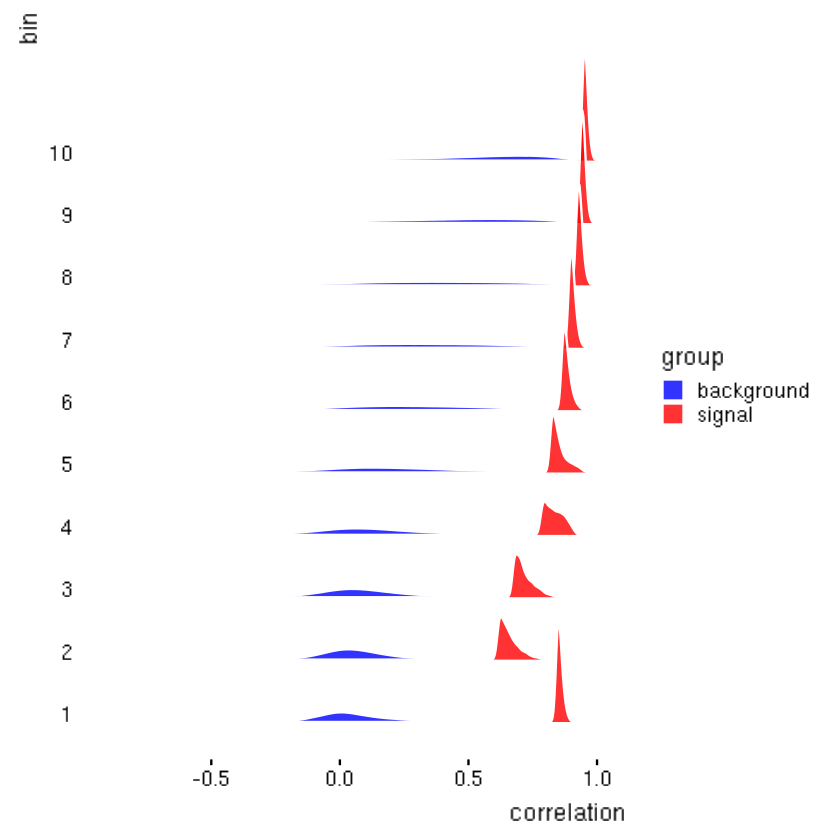

In [37]:
plot_signal_condition_exp(adjacency, avg.exp, signal=0.001)

In [40]:
adjacency.norm <- normalize_correlation(adjacency, ave_exp=avg.exp, ngrp=20, size_grp=1000, ref_grp=8)

Warning message:
“Continuous limits supplied to discrete scale.
Did you mean `limits = factor(...)` or `scale_*_continuous()`?”
Picking joint bandwidth of 0.00871



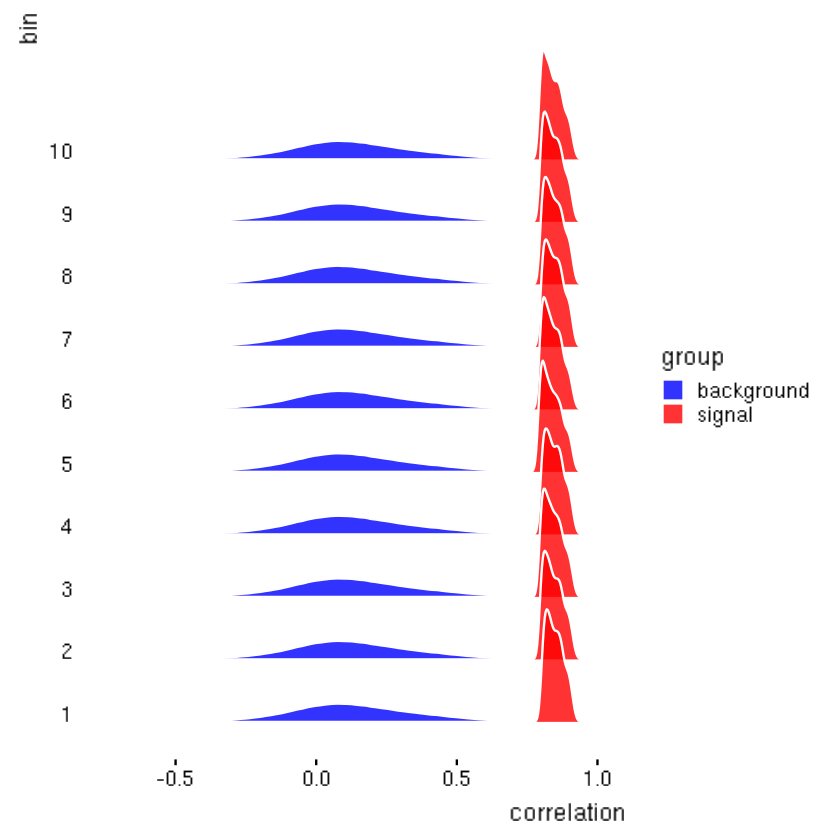

In [41]:
plot_signal_condition_exp(adjacency.norm, avg.exp, signal=0.001)

## Network Transformation

Instead of WTO (which is used in WGCNA), I will use Context Likelihood of Relatedness (CLR) as recommended by Johnson and Krishnan 2022.

Although Johnson and Krishnan used an implementation from [Sleipnir](https://functionlab.github.io/sleipnir-docs/index.html), it is a large C++ program that I do not need in its entirety. Instead, I rewrote a C++ version of CLR for myself.

In [42]:
network <- clr(abs(adjacency.norm))

In [43]:
rownames(network) <- rownames(adjacency)
colnames(network) <- colnames(adjacency)

In [44]:
head(network)

,ENSG00000285647,ENSG00000204435,ENSG00000231074,ENSG00000206337,ENSG00000206503,ENSG00000234745,ENSG00000204525,ENSG00000204257,ENSG00000242574,ENSG00000204252,⋯,ENSG00000288156,ENSG00000288234,ENSG00000288253,ENSG00000288302,ENSG00000288398,ENSG00000288538,ENSG00000288559,ENSG00000288562,ENSG00000288573,ENSG00000288582
ENSG00000285647,10.9000318,0.3729141,0.9792448,3.7016321,4.3825868,3.9104236,5.1680969,0.4495094,0.2898863,1.7397549,⋯,1.0419991,0.6114170,1.1181726,0.7879613,1.0836743,0.3277168,0.8305462,0.4020441,0.9393274,1.4733580
ENSG00000204435,0.3729141,8.3265002,1.3101724,1.4199331,1.7129524,2.1222697,1.6760031,1.4491835,1.2114696,0.5732327,⋯,2.1778532,1.3330530,1.1269846,4.1026515,1.2741225,0.4738586,1.0502315,1.0296571,1.5976494,0.4724222
ENSG00000231074,0.9792448,1.3101724,6.4256889,0.4884744,1.3035068,1.0500975,0.6141062,0.1538053,0.5285614,2.0149455,⋯,1.2610615,1.1356899,2.1643139,0.1371844,3.5201653,1.5930148,1.0760480,0.6307351,3.4741579,0.4543633
ENSG00000206337,3.7016321,1.4199331,0.4884744,9.4044545,0.9005129,0.5992169,0.1566312,0.9161303,0.2283525,0.1502369,⋯,0.1505476,0.6227213,0.6977414,1.7680130,1.4268188,0.5944116,1.9985195,0.2393041,1.3007144,0.9315999
ENSG00000206503,4.3825868,1.7129524,1.3035068,0.9005129,10.7917166,4.1045786,2.8576795,1.0119414,0.9280381,1.6311731,⋯,1.1382894,0.9650078,1.5774921,2.3391661,0.5960292,0.4781792,1.4204280,0.8408953,0.7650515,2.2403784
ENSG00000234745,3.9104236,2.1222697,1.0500975,0.5992169,4.1045786,9.8123693,6.2252299,1.2595667,1.1753597,1.6700773,⋯,0.4022011,1.6173627,1.0871493,2.7502482,0.6882708,0.6456049,0.9019872,0.4303269,1.5282073,2.3255622


## Module Construction

### Clustering

I use spectral clustering to generate modules from the network. I begin by generating a weighted adjacency matrix $W$ with no self-edges. I use $W$ to generate the degree matrix $D$ for the network. I use the unnormalized graph Laplacian, which is defined as

$$L=D - W$$

I calculate the spectrum of the Laplacian using `eigen()` and order the eigenvectors by increasing eigenvalues. Spectral clustering works by using the first $k$ eigenvectors to create $k$ clusters of the original samples. I use the first 1000 eigenvectors and keep any clusters that have more than 10 genes in them.

In [45]:
network.adjacency <- network
diag(network.adjacency) <- 0

network.degree <- diag(colSums(network.adjacency))

graph.laplacian <- network.degree - network.adjacency

In [26]:
graph.laplacian.file <- "~/gains_team282/nikhil/expression/gene_expression/graph.laplacian.clr.RDS"
if (file.exists(graph.laplacian.file)) {
    laplacian.eigen <- readRDS(graph.laplacian.file)
} else {
    laplacian.eigen <- eigen(graph.laplacian, symmetric=TRUE)
    laplacian.eigen$values <- laplacian.eigen$values[rev(1:nrow(network))]
    laplacian.eigen$vectors <- laplacian.eigen$vectors[,rev(1:nrow(network))]
    saveRDS(laplacian.eigen, graph.laplacian.file)
}

K-means clustering on the first $k=1000$ eigenvectors.

In [27]:
features <- laplacian.eigen$vectors[,1:1000]

In [28]:
graph.kmeans.file <- "~/gains_team282/nikhil/expression/gene_expression/graph.laplacian.kmeans.clr.RDS"
if (file.exists(graph.kmeans.file)) {
    features.kmeans <- readRDS(graph.kmeans.file)
} else {
    set.seed(5829824)
    features.kmeans <- kmeans(features, centers=1000, iter.max=1000, nstart=10)
    saveRDS(features.kmeans, graph.kmeans.file)
}

There are 13 clusters that have more than 10 genes in them. The rest of the genes will not be assigned to any modules.

In [29]:
n.modules <- sum(table(features.kmeans$cluster) > 10)
n.modules

[1] 13

Generate modules by removing all clusters that have 10 or fewer genes.

In [30]:
modules.all <- features.kmeans$cluster

small.clusters <- as.numeric(names(table(modules.all))[table(modules.all) <= 10])

modules.all[modules.all %in% small.clusters] <- 0

Reorder modules by size.

In [31]:
module.label.map <- as.list(0:n.modules)
modules.non.zero <- modules.all[modules.all != 0]
names(module.label.map) <- c("0", names(table(modules.non.zero))[order(table(modules.non.zero), decreasing=TRUE)])

In [32]:
modules <- sapply(modules.all, function(gene.assignment) { module.label.map[[as.character(gene.assignment)]] })

In [33]:
table(modules)

modules
   0    1    2    3    4    5    6    7    8    9   10   11   12   13 
 991 4970 2525 1843 1745 1669 1662 1420  755  453  367  211   52   18 

### Module Refinement

In [34]:
connectivity <- WGCNA::intramodularConnectivity(adjacency, modules)

In [35]:
connectivity <- connectivity %>%
    dplyr::mutate(kRatio = kWithin / kOut)

The module eigengenes do not explain a majority of the variation present in the module. I will prune genes based on their correlation with the module eigengene. If the gene has an absolute correlation of greater than 0.5 with the module eigengene, I will keep it in the pruned modules.

In [48]:
modules.pruned <- modules

In [49]:
for (module in 1:n.modules) {
    
    module.exp = scale(gene.exp[, modules == module])

    svd.res = svd(module.exp)
    module.eigen = svd.res$u[,1]

    genes.to.prune = colnames(module.exp)[abs(cor(module.eigen, module.exp)) < 0.8]
    modules.pruned[colnames(gene.exp) %in% genes.to.prune] <- 0
}

In [50]:
table(modules.pruned)

modules.pruned
    0     1     2     3     4     5     6     7     8     9    10    11    12 
13320   795  1506   308   836   516   581   489    38    83    56   102    40 
   13 
   11 

Graph the increase in the variance explained after pruning.

In [51]:
var.explained <- sapply(
    1:n.modules,
    function(k) {
        pca.original = prcomp(scale(gene.exp[,modules == k]))
        pca.pruned = prcomp(scale(gene.exp[,modules.pruned == k]))
        prop.original = summary(pca.original)$importance["Proportion of Variance", "PC1"]
        prop.pruned = summary(pca.pruned)$importance["Proportion of Variance", "PC1"]
        c(prop.original, prop.pruned)
    }
)

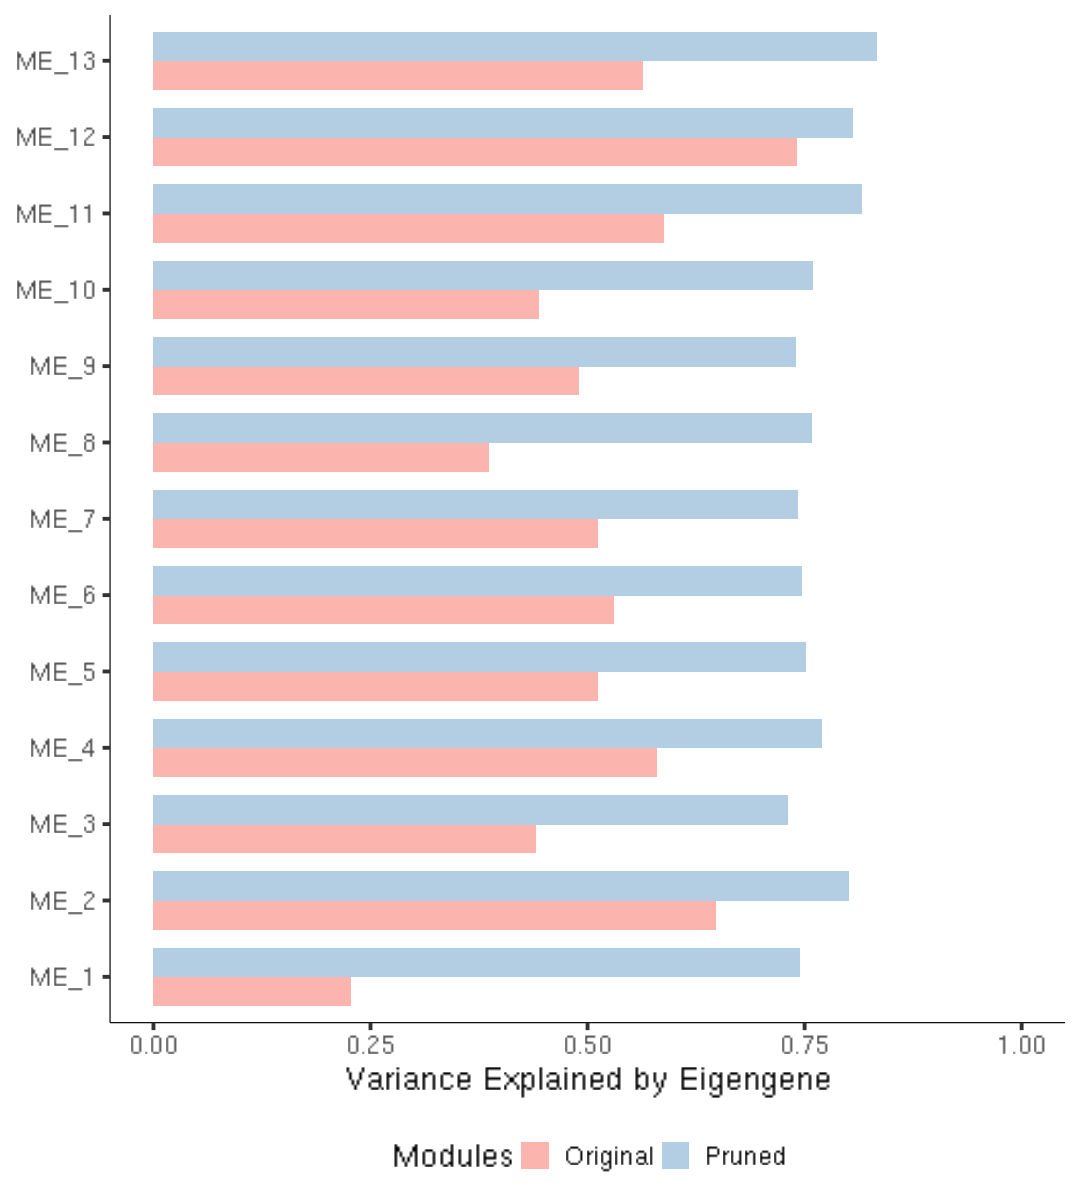

In [52]:
options(repr.plot.width=9, repr.plot.height=10)

data.frame(
    Module=paste0("ME_", 1:n.modules),
    Original=var.explained[1,],
    Pruned=var.explained[2,]
) %>%
    tidyr::gather("Modules", "Var.Explained", -Module) %>%
    dplyr::mutate(Module=factor(Module, levels=paste0("ME_", 1:n.modules))) %>%
    dplyr::mutate(Modules=factor(Modules, levels=c("Original", "Pruned"))) %>%
    ggplot() +
    geom_bar(aes(x=Module, y=Var.Explained, fill=Modules), stat="identity", position=position_dodge(0.75), width=0.75) +
    scale_fill_brewer(palette="Pastel1") +
    coord_flip() +
    ylab("Variance Explained by Eigengene") +
    ylim(0, 1) +
    ggplot_theme +
    theme(axis.title.y=element_blank())

## Save Modules

First, I will reassign module numbering by the number of genes in each module in descending order. All genes that were filtered out in the process of generating co-expression modules will be assigned to Module 0.

In [53]:
gene.modules <- data.frame(
    Gene=rownames(network),
    Module=modules,
    Module.Pruned=modules.pruned
) %>%
    dplyr::arrange(Module) %>%
    dplyr::mutate(Module=paste0("Module_", Module)) %>%
    dplyr::mutate(Module.Pruned=paste0("Module_", Module.Pruned)) %>%
    dplyr::mutate(Module=ifelse(Module == "Module_0", "Unassigned", Module)) %>%
    dplyr::mutate(Module.Pruned=ifelse(Module.Pruned == "Module_0", "Unassigned", Module.Pruned))

I'll calculate the first principal component for each module to get the module eigengenes.

In [54]:
module.eigens <- sapply(1:n.modules, function(k) { svd(scale(gene.exp[,modules.pruned == k]))$u[,1] })

In [55]:
colnames(module.eigens) <- paste0("ME_", 1:n.modules)
rownames(module.eigens) <- rownames(gene.exp)

module.eigens <- module.eigens %>%
    as.data.frame() %>%
    dplyr::mutate(Sample.ID=rownames(.)) %>%
    dplyr::select(Sample.ID, everything())

In [56]:
head(module.eigens)

,Sample.ID,ME_1,ME_2,ME_3,ME_4,ME_5,ME_6,ME_7,ME_8,ME_9,ME_10,ME_11,ME_12,ME_13
,<chr>,<dbl>,<dbl>,<dbl>,<dbl>,<dbl>,<dbl>,<dbl>,<dbl>,<dbl>,<dbl>,<dbl>,<dbl>,<dbl>
UK02270173_3,UK02270173_3,-0.026880028,0.024754255,-0.049255630,-0.0011365576,-0.02004220,-0.011621161,-0.048982210,0.001510054,-0.03801025,0.001552109,0.002506806,-0.01010815,-0.018126419
UK15130120_3,UK15130120_3,-0.012686164,-0.012329614,-0.049890308,0.0117096753,-0.05134518,0.011795701,-0.032446820,-0.006916683,-0.01832666,0.022868622,0.023239704,-0.01033057,-0.001873539
UK58000006_3,UK58000006_3,-0.007422916,0.019682349,-0.003439649,-0.0004373064,0.01823638,-0.037003556,-0.026203330,0.013285317,-0.00654476,-0.034106149,-0.033193160,0.01994496,0.021248987
UK47010004_3,UK47010004_3,0.010860942,0.005580810,-0.001070395,-0.0123976557,0.01688644,-0.002396543,0.010436675,-0.009976259,-0.03845000,0.044978110,0.013607013,-0.04736191,-0.021150863
UK42020088_5,UK42020088_5,-0.020354540,0.013730057,-0.005233625,-0.0288076192,-0.01357106,0.034517070,-0.003360994,0.013865936,-0.03183148,-0.032342665,-0.018588091,0.02292120,0.003827274
UK47490007_3,UK47490007_3,0.007358504,-0.007576762,-0.004897662,-0.0114631104,-0.02199959,0.033353492,0.015936130,-0.046998162,-0.01985218,0.043605091,0.074601996,-0.02636748,-0.015488821


In [57]:
var.explained <- sapply(
    1:n.modules,
    function(k) { summary(prcomp(scale(gene.exp[,modules.pruned == k])))$importance["Proportion of Variance", "PC1"] }
)

In [58]:
module.var.explained <- data.frame(
    Module=paste0("ME_", 1:n.modules),
    Var.Explained=var.explained
)

head(module.var.explained)

,Module,Var.Explained
,<chr>,<dbl>
1,ME_1,0.74466
2,ME_2,0.80053
3,ME_3,0.72997
4,ME_4,0.76935
5,ME_5,0.75126
6,ME_6,0.74689


In [59]:
write.csv(gene.modules, "/nfs/users/nfs_n/nm18/gains_team282/nikhil/expression/gene_expression/modules.clr.csv", quote=F, row.names=F)
write.csv(module.eigens, "/nfs/users/nfs_n/nm18/gains_team282/nikhil/expression/gene_expression/eigengenes.clr.csv", quote=F, row.names=F)
write.csv(module.var.explained, "/nfs/users/nfs_n/nm18/gains_team282/nikhil/expression/gene_expression/variance.explained.clr.csv", quote=F, row.names=F)